# 目標：
- 希望能爬取："公司名稱", "工作職缺", "更新日期", "URL", "工作內容", "職務類別", "工作待遇", "工作性質", "上班地點", "上班時段", "休假制度", "可上班日", "工作經歷", "語文條件", "擅長工具", "工作技能", "其他條件", "其他福利"
- 使用者可以自由輸入要爬取幾頁

# 思考
1. 進入目標104網站後，解析網頁
2. 設法取得 HTML 原始碼，並交由 requests 及 BeautifulSoup 套件抓取目標資訊
3. 存入CSV

做法如下：

### 觀察網頁狀況

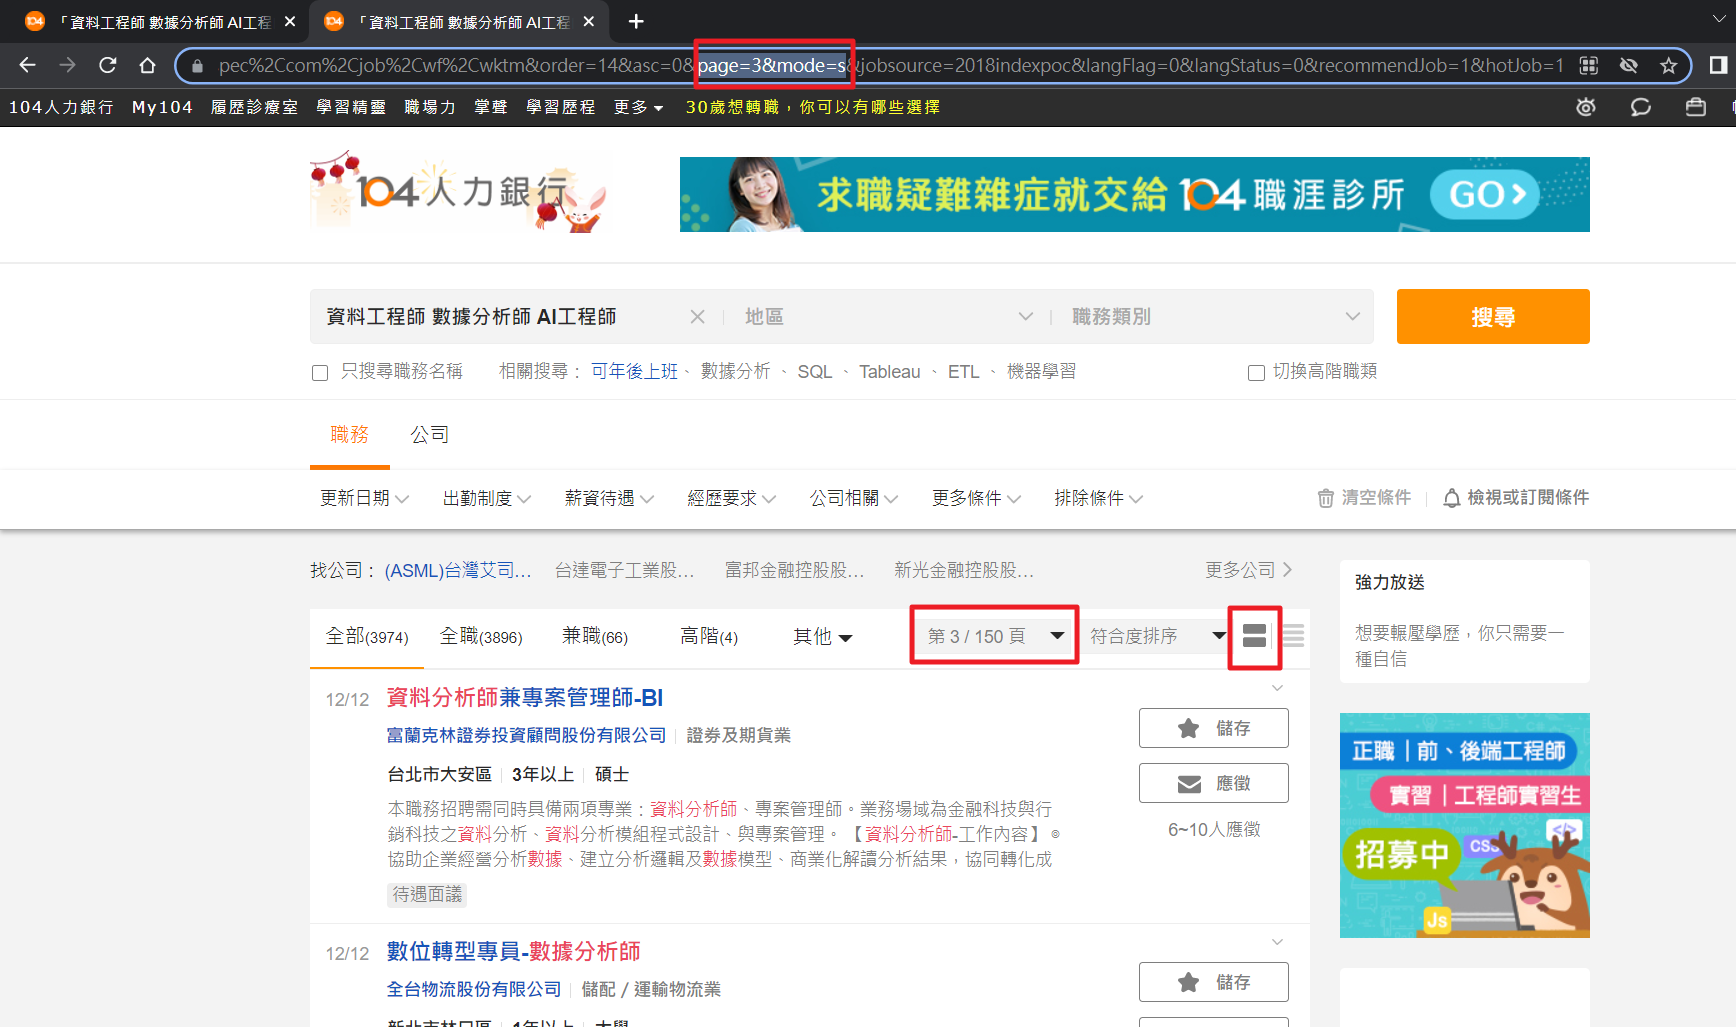

- 在首頁輸入關鍵字後，可以觀察到頁面式動態網頁，且是以get 的方式執行請求
- 觀察到網址列?後面帶的參數，page可以手動帶入換頁。例如 page=3 則表示在第三頁
- mode=s 表示正常的區塊瀏覽；mode=s 則會以表格形式瀏覽
- 觀察到其他參數去掉後，不會影響網頁的內容

所以接下來 除了關鍵字之外，文字盡量縮減，後面的參數改以 page={}&mode=s 的方式帶入URL <br>
另外也發現有些職缺頁面，並非每個欄位都有資料，所以必須針對各個column 分別處理錯誤例外訊息。

In [1]:
from selenium import webdriver
import requests
from bs4 import BeautifulSoup
import pandas as pd


由於希望請使用者輸入正整數以便輸入爬取幾頁的資訊，設計給使用者可以容錯2次的機會，並提示使用者還剩下幾次機會輸入，若第三次仍輸入錯誤，則直接結束程式。

In [2]:
for i in range(3):
    try:
        print("將會進入104人力銀行爬取「資料工程師 數據分析師 AI工程師」相關職缺...")
        page = int(input("請輸入要爬取的頁數(正整數)： "))
        break
    except:
        print("請輸入一個正確的整數,你還有次{}機會".format(2-i))


        
pg = 1
driver = webdriver.Chrome('./chromedriver')
data = []

for i in range(page):
    url = "https://www.104.com.tw/jobs/search/?ro=0&keyword=%E8%B3%87%E6%96%99%E5%B7%A5%E7%A8%8B%E5%B8%AB%20%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90%E5%B8%AB%20AI%E5%B7%A5%E7%A8%8B%E5%B8%AB&page={}&mode=s".format(pg)


    # 將 url 填入瀏覽器，發出頁面請求
    driver.get(url)

    cookie = driver.get_cookies()
    ss = requests.session()
    res = ss.get(url)
    soup = BeautifulSoup(res.text, "html.parser")
    main_list = soup.select('#js-job-content > article > div.b-block__left > h2 > a')
    # print(main_list)
    
    for job_link_list in main_list:

        job_url = "https:" + job_link_list["href"]
        print(job_url)
        # 透過 selenium 進入職缺頁面:
        driver.get(job_url)
        contain_res = ss.get(job_url)
        contain_soup = BeautifulSoup(contain_res.text, "html.parser")

        try:
            company_name = contain_soup.select_one('#app div.job-header div.job-header__title a')['title']
            # print(company_name)
        except AttributeError as e:
            print(e)
            company_name = ""
        except:
            company_name = ""
        
        try:
            job_name = contain_soup.select_one('#app div.job-header div.job-header__title > h1')['title']
            # print(job_name)
        except AttributeError as e:
            print(e)
            job_name = ""
        except:
            job_name = ""
            
        try:
            update = contain_soup.select_one('#app div.job-header div.job-header__title > h1 > span > span')['title'].replace("更新", "")
            # print(update)
        except AttributeError as e:
            print(e)
            update = ""
        except:
            update = ""
            
        try:
            job_content = contain_soup.select_one('#app div.jb-container div.job-description > div.job-description-table > div.job-description > p').text
            # print(job_content)
        except AttributeError as e:
            print(e)
            job_content = ""
        except:
            job_content = ""
            
            
        job_category_list = []
        try:
            temp = contain_soup.select('#app div.jb-container div.job-description > div.job-description-table div:nth-child(n) u')
        except AttributeError as e:
            print(e)
            temp = ""
        except:
            temp = ""
        for cat in temp:
        #     print(cat.text)
            job_category_list.append(cat.text)

        job_category = "、".join(job_category_list)
        # print(job_category)

        try:
            sallary = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-description.mb-4.pt-6.pb-6 > div.job-description-table.row > div.list-row.row.mb-2.identity-type > div.col.p-0.list-row__data > div').text
            # print(sallary)
        except AttributeError as e:
            print(e)
            sallary = ""
        except:
            sallary = ""
            
        try:
            job_nature = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-description.mb-4.pt-6.pb-6 > div.job-description-table.row > div:nth-child(4) > div.col.p-0.list-row__data > div').text
            # print(job_nature)
        except AttributeError as e:
            print(e)
            job_nature = ""
        except:
            job_nature = ""            
        
        try:
            work_place = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-description.mb-4.pt-6.pb-6 > div.job-description-table.row > div:nth-child(5) > div.col.p-0.list-row__data > div > div > span').text
            # print(work_place)
        except AttributeError as e:
            print(e)
            work_place = ""
        except:
            work_place = "" 
            
        try:
            working_hours = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-description.mb-4.pt-6.pb-6 > div.job-description-table.row > div:nth-child(9) > div.col.p-0.list-row__data').text
            # print(working_hours)
        except AttributeError as e:
            print(e)
            working_hours = ""
        except:
            working_hours = "" 
            
        try:
            holiday = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-description.mb-4.pt-6.pb-6 > div.job-description-table.row > div:nth-child(10) > div.col.p-0.list-row__data').text
            # print(holiday)
        except AttributeError as e:
            print(e)
            holiday = ""
        except:
            holiday = ""
            
            
        try:
            onboard_date = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-description.mb-4.pt-6.pb-6 > div.job-description-table.row > div:nth-child(11) > div.col.p-0.list-row__data').text
            # print(onboard_date)
        except AttributeError as e:
            print(e)
            onboard_date = ""
        except:
            onboard_date = ""

            # 條件區塊
        try:
            experience = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-requirement.mb-4.pt-6.pb-6 > div.job-requirement-table.row > div:nth-child(1) > div.col.p-0.list-row__data').text
            # print(experience)
        except AttributeError as e:
            print(e)
            experience = ""
        except:
            experience = ""
            
        try:
            language = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-requirement.mb-4.pt-6.pb-6 > div.job-requirement-table.row > div:nth-child(4) > div.col.p-0.list-row__data > div > p').text
            # print(language)
        except AttributeError as e:
            print(e)
            language = ""
        except:
            language = ""
            
        try:
            tools = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-requirement.mb-4.pt-6.pb-6 > div.job-requirement-table.row > div:nth-child(5) > div.col.p-0.list-row__data > div').text.replace("贊助提升專業能力", "").strip()
            # print(tools)
        except AttributeError as e:
            print(e)
            tools = ""
        except:
            tools = ""
            
        try:
            skill = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-requirement.mb-4.pt-6.pb-6 > div.job-requirement-table.row > div:nth-child(6) > div.col.p-0.list-row__data > div').text.strip()
            # print(skill)
        except AttributeError as e:
            print(e)
            skill = ""
        except:
            skill = ""
            
        try:
            other_conditions = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.job-requirement.mb-4.pt-6.pb-6 > div.job-requirement.col.opened > div > div.col.p-0.list-row__data > div > div').text
            # print(other_conditions)
        except AttributeError as e:
            print(e)
            other_conditions = ""
        except:
            other_conditions = ""
            
        try:
            other_bebefits = contain_soup.select_one('#app > div > div.container.jb-container.pt-4.position-relative > div > div.col.main > div.dialog.container-fluid.bg-white.rounded.benefits.mb-4.pt-6.pb-6 > div.row.benefits-description > div > p').text
            # print(other_bebefits)
        except AttributeError as e:
            print(e)
            other_bebefits = ""
        except:
            other_bebefits = ""
            
        row = [company_name, job_name, update, job_url, job_content, job_category, sallary, job_nature, work_place, working_hours, holiday, onboard_date, experience, language, tools, skill, other_conditions, other_bebefits]
        data.append(row)

    pg += 1

driver.close()

columns = ["公司名稱", "工作職缺", "更新日期", "URL", "工作內容", "職務類別", "工作待遇", "工作性質", "上班地點", "上班時段", "休假制度", "可上班日", "工作經歷", "語文條件", "擅長工具", "工作技能", "其他條件", "其他福利"]
df = pd.DataFrame(data=data, columns= columns)

# 存成 CSV
df.to_csv("./TGI103_09_黃俊儒_homework104.csv", index = 0, encoding="utf-8-sig")

將會進入104人力銀行爬取「資料工程師 數據分析師 AI工程師」相關職缺...
請輸入要爬取的頁數(正整數)： 3


c:\python_etl\venv\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  if sys.path[0] == "":


https://www.104.com.tw/job/7mvyx?jobsource=hotjob_chr
https://www.104.com.tw/job/7tymb?jobsource=hotjob_chr
https://www.104.com.tw/job/7f4u4?jobsource=hotjob_chr
https://www.104.com.tw/job/7t7rv?jobsource=jolist_d_relevance
https://www.104.com.tw/job/7sxjg?jobsource=jolist_d_relevance
https://www.104.com.tw/job/7h3xf?jobsource=jolist_d_relevance
https://www.104.com.tw/job/7qwdd?jobsource=jolist_d_relevance
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
https://www.104.com.tw/job/7o52w?jobsource=jolist_d_relevance
https://www.104.com.tw/job/7fjfp?jobsource=jolist_d_relevance
https://www.104.com.tw/job/6gj80?jobsource=jolist_d_relevance
https://www.104.com.tw/job/7scrv?jobsource=jolist_d_relevance
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneT

## 存入CSV檔案結果截圖:
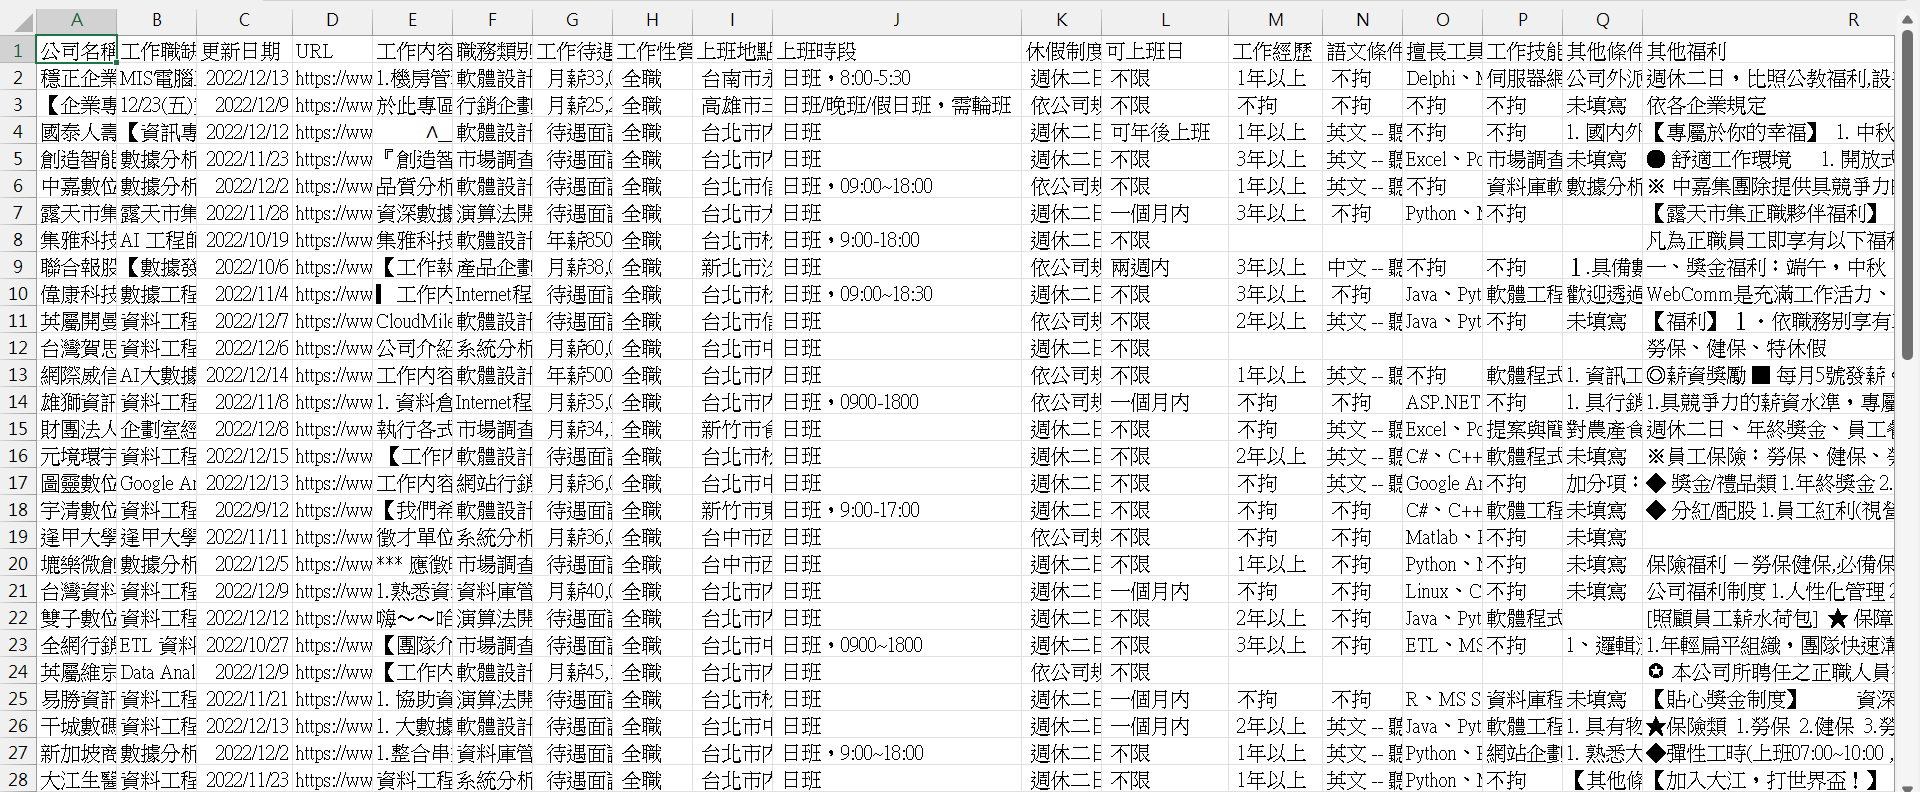